# 数据可视化

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.io as sio
import numpy as np

In [2]:
mat = sio.loadmat('./data/ex7data1.mat')
data1 = pd.DataFrame(mat.get('X'), columns=['X1', 'X2'])
data1.head()

,X1,X2
0,3.381563,3.389113
1,4.527875,5.854178
2,2.655682,4.411995
3,2.765235,3.715414
4,2.846560,4.175506


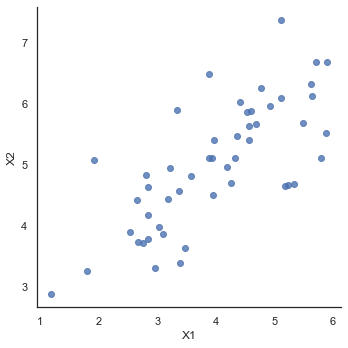

In [4]:
sns.set(context="notebook", style="white")
sns.lmplot(x='X1', y='X2', data=data1, fit_reg=False)
plt.show()

In [5]:
mat = sio.loadmat('./data/ex7data2.mat')
data2 = pd.DataFrame(mat.get('X'), columns=['X1', 'X2'])
data2.head()

,X1,X2
0,1.842080,4.607572
1,5.658583,4.799964
2,6.352579,3.290854
3,2.904017,4.612204
4,3.231979,4.939894


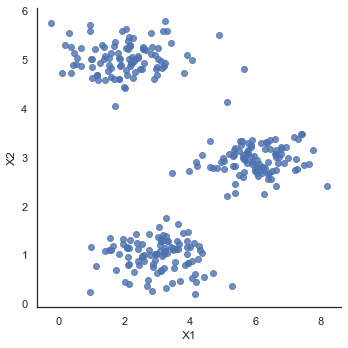

In [7]:
sns.lmplot(x='X1', y='X2', data=data2, fit_reg=False)
plt.show()

# random init cluster centroids

In [31]:
def random_init(data, k):
    """choose k sample from data set as init centroids
    Args:
        data: DataFrame
        k: int
    Returns:
        k samples: ndarray
    """
    return data.sample(k).values # sample(n) : 它返回与调用者相同类型的新对象, 其中包含从调用者对象中随机采样的n个项目。

def _find_your_cluster(x, centroids):
    """find the right cluster for x with respect to shortest distance
    Args:
        x: ndarray (n, ) -> n features
        centroids: ndarray (k, n)
    Returns:
        k: int
    """
    distance = np.apply_along_axis(func1d=np.linalg.norm, # 求范数，默认为二范数
                                   axis=1,
                                   arr=centroids - x)
    return np.argmin(distance)

def assign_cluster(data, centroids): # 分配 cluster
    """assign cluster for each node in data
    return C ndarray
    """
    return np.apply_along_axis(lambda x: _find_your_cluster(x, centroids),
                               axis=1,
                               arr=data.values)
    
def combine_data_C(data, C):
    data_with_c = data.copy()
    data_with_c['C'] = C
    return data_with_c

def new_centroids(data, C): # 移动 centroids
    data_with_c = combine_data_C(data, C)
    
    return data_with_c.groupby('C', as_index=False).\
                       mean().\
                       sort_values(by='C').\
                       drop('C', axis=1).\
                       values
                       
                       
def cost(data, centroids, C):
    m = data.shape[0]
    
    expend_C_with_centroids = centroids[C]

    distances = np.apply_along_axis(func1d=np.linalg.norm,
                                    axis=1,
                                    arr=data.values - expend_C_with_centroids)
    return distances.sum() / m

def _k_means_iter(data, k, epoch=100, tol=0.0001):
    centroids = random_init(data, k)
    cost_progress = []
    
    for i in range(epoch):
        print('running epoch {}'.format(i))
        C = assign_cluster(data, centroids)
        centroids = new_centroids(data, C)
        cost_progress.append(cost(data, centroids, C))
        if len(cost_progress) > 1:
            if (np.abs(cost_progress[-1] - cost_progress[-2])) / cost_progress[-1] < tol: # cost function 收敛
                break
    return C, centroids, cost_progress[-1]


def k_means(data, k, epoch=100, n_init=10): # 多次 init centroids 寻找最佳的 init
    """do multiple random init and pick the best one to return
    Args:
        data (pd.DataFrame)
    Returns:
        (C, centroids, least_cost)
    """

    tries = np.array([_k_means_iter(data, k, epoch) for _ in range(n_init)], dtype=object)

    least_cost_idx = np.argmin(tries[:, -1])

    return tries[least_cost_idx]
    

In [15]:
random_init(data2, 3)

array([[3.02836363, 1.35635189],
       [3.41156277, 1.1596363 ],
       [0.31319845, 5.54694644]])

In [17]:
init_centroids = random_init(data2, 3)
init_centroids

array([[2.42865879, 0.86499285],
       [2.80996442, 5.53849899],
       [3.08349136, 1.19632644]])

In [18]:
C = assign_cluster(data2, init_centroids)
data_with_c = combine_data_C(data2, C)
data_with_c.head()

,X1,X2,C
0,1.842080,4.607572,1
1,5.658583,4.799964,1
2,6.352579,3.290854,2
3,2.904017,4.612204,1
4,3.231979,4.939894,1


> See the first round clustering result

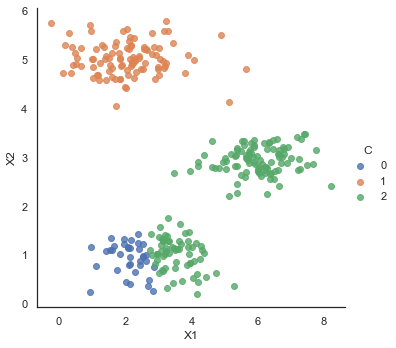

In [19]:
sns.lmplot(x='X1', y='X2', hue='C', data=data_with_c, fit_reg=False)
plt.show()

In [20]:
new_centroids(data2, C)

array([[2.10332926, 0.92793263],
       [2.05132113, 5.01925539],
       [5.04545636, 2.18269858]])

# putting all together, take1
this is just 1 shot `k-means`, if the random init pick the bad starting centroids, the final clustering may be very sub-optimal

只 random init cluster 一次

In [26]:
final_C, final_centroid, _= _k_means_iter(data2, 3)
data_with_c = combine_data_C(data2, final_C)

running epoch 0
running epoch 1
running epoch 2
running epoch 3
running epoch 4


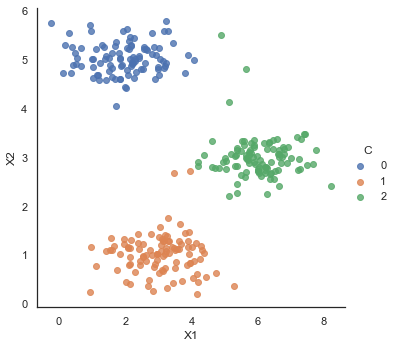

In [28]:
sns.lmplot(x='X1', y='X2', hue='C', data=data_with_c, fit_reg=False)
plt.show()

In [29]:
cost(data2, final_centroid, final_C)

0.794176363371587

# k-mean with multiple tries of randome init, pick the best one with least cost

In [32]:
best_C, best_centroids, least_cost = k_means(data2, 3)

running epoch 0
running epoch 1
running epoch 2
running epoch 3
running epoch 0
running epoch 1
running epoch 2
running epoch 0
running epoch 1
running epoch 2
running epoch 3
running epoch 4
running epoch 0
running epoch 1
running epoch 2
running epoch 3
running epoch 4
running epoch 0
running epoch 1
running epoch 2
running epoch 3
running epoch 4
running epoch 0
running epoch 1
running epoch 2
running epoch 3
running epoch 4
running epoch 5
running epoch 0
running epoch 1
running epoch 2
running epoch 3
running epoch 0
running epoch 1
running epoch 2
running epoch 3
running epoch 4
running epoch 5
running epoch 6
running epoch 0
running epoch 1
running epoch 2
running epoch 0
running epoch 1
running epoch 2
running epoch 3


In [33]:
least_cost

0.794176363371587

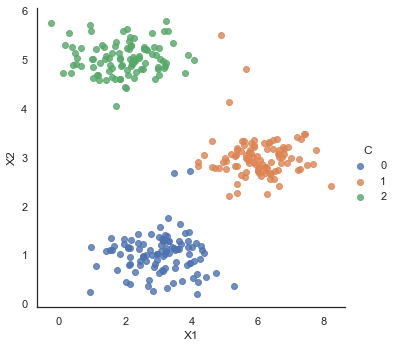

In [35]:
data_with_c = combine_data_C(data2, best_C)
sns.lmplot(x='X1', y='X2', hue='C', data=data_with_c, fit_reg=False)
plt.show()

# try sklearn kmeans

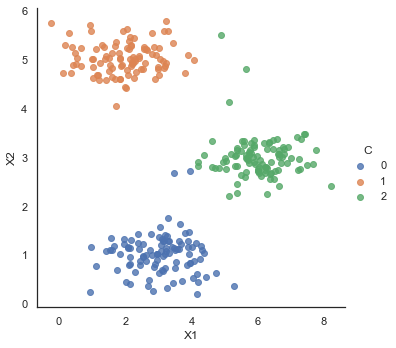

In [37]:
from sklearn.cluster import KMeans

sk_kmeans = KMeans(n_clusters=3)
sk_kmeans.fit(data2)
sk_C = sk_kmeans.predict(data2)
data_with_c = combine_data_C(data2, sk_C)
sns.lmplot(x='X1', y='X2', hue='C', data=data_with_c, fit_reg=False)
plt.show()